In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import seaborn as sns
from imblearn.over_sampling import SMOTE 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_csv('datasets/Dataset-SA.csv')

In [3]:
len(data)

205052

In [4]:
data['text'] = data['Review'].fillna('') + ' ' + data['Summary'].fillna('')
data['text'] = data['text'].str.strip()
data = data[data['text'] != '']
data = data.dropna(subset=['Rate', 'Sentiment'])

In [5]:

data['score'] = data['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

In [6]:
data.head()

,product_name,product_price,Rate,Review,Summary,Sentiment,text,score
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive,super! great cooler excellent air flow and for...,1
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive,awesome best budget 2 fit cooler nice cooling,1
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive,fair the quality is good but the power of air ...,1
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative,useless product very bad product its a only a fan,-1
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral,fair ok ok product,0


In [7]:
# sentiment distribution
data['score'].value_counts()
data['score'].value_counts() / len(data) * 100

score
 1    81.238722
-1    13.768349
 0     4.992929
Name: count, dtype: float64

In [8]:
data['text_length'] = data['text'].str.len()
data['text_length'].max(), data['text_length'].min(), data['text_length'].mean()

(616, 2, np.float64(54.207881004633016))

In [9]:
X = data['text']
y = data['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
len(X_train), len(X_test)

(164040, 41010)

In [11]:
vectorizer_bow = CountVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

In [12]:
smote = SMOTE(random_state=42)
X_train_bow_balanced, y_train_balanced = smote.fit_resample(X_train_bow, y_train)
X_train_tfidf_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

pd.Series(y_train_balanced).value_counts()

score
 1    133264
-1    133264
 0    133264
Name: count, dtype: int64

In [13]:
# Naive Bayes (BoW)
nb_model = MultinomialNB()
nb_model.fit(X_train_bow_balanced, y_train_balanced)
y_pred_nb = nb_model.predict(X_test_bow)
print("\nNaive Bayes (BoW) Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb, zero_division=0))
print("Macro F1-score:", f1_score(y_test, y_pred_nb, average='macro'))


Naive Bayes (BoW) Accuracy: 0.8990733967325043
Classification Report:
               precision    recall  f1-score   support

          -1       0.84      0.82      0.83      5646
           0       0.36      0.53      0.43      2048
           1       0.96      0.94      0.95     33316

    accuracy                           0.90     41010
   macro avg       0.72      0.76      0.73     41010
weighted avg       0.91      0.90      0.90     41010

Macro F1-score: 0.7340568832930098


In [14]:
# Logistic Regression (BoW)
lr_model_bow = LogisticRegression(max_iter=1000, penalty='l2', C=1.0, multi_class='ovr', class_weight='balanced')
lr_model_bow.fit(X_train_bow_balanced, y_train_balanced)
y_pred_lr_bow = lr_model_bow.predict(X_test_bow)
print("\nLogistic Regression (BoW) Accuracy:", accuracy_score(y_test, y_pred_lr_bow))
print("Classification Report:\n", classification_report(y_test, y_pred_lr_bow, zero_division=0))
print("Macro F1-score:", f1_score(y_test, y_pred_lr_bow, average='macro'))

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (BoW) Accuracy: 0.862033650329188
Classification Report:
               precision    recall  f1-score   support

          -1       0.82      0.84      0.83      5646
           0       0.25      0.62      0.36      2048
           1       0.97      0.88      0.92     33316

    accuracy                           0.86     41010
   macro avg       0.68      0.78      0.70     41010
weighted avg       0.91      0.86      0.88     41010

Macro F1-score: 0.7044313225954492


In [15]:
# LinearSVM (TF-IDF)
svm_model = LinearSVC(C=1.0, class_weight={-1: 2, 0: 3, 1: 1}, max_iter=1000)
svm_model.fit(X_train_tfidf_balanced, y_train_balanced)
y_pred_svm = svm_model.predict(X_test_tfidf)
print("\nLinearSVC (TF-IDF) Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm, zero_division=0))
print("Macro F1-score:", f1_score(y_test, y_pred_svm, average='macro'))



LinearSVC (TF-IDF) Accuracy: 0.8610582784686662
Classification Report:
               precision    recall  f1-score   support

          -1       0.77      0.81      0.79      5646
           0       0.28      0.70      0.40      2048
           1       0.98      0.88      0.93     33316

    accuracy                           0.86     41010
   macro avg       0.68      0.80      0.71     41010
weighted avg       0.92      0.86      0.88     41010

Macro F1-score: 0.7053350877659841


In [16]:
# Logistic Regression (TF-IDF)
lr_model_tfidf = LogisticRegression(max_iter=1000, penalty='l2', C=1.0, multi_class='ovr', class_weight='balanced')
lr_model_tfidf.fit(X_train_tfidf_balanced, y_train_balanced)
y_pred_lr_tfidf = lr_model_tfidf.predict(X_test_tfidf)
print("\nLogistic Regression (TF-IDF) Accuracy:", accuracy_score(y_test, y_pred_lr_tfidf))
print("Classification Report:\n", classification_report(y_test, y_pred_lr_tfidf, zero_division=0))
print("Macro F1-score:", f1_score(y_test, y_pred_lr_tfidf, average='macro'))

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (TF-IDF) Accuracy: 0.8918068763716167
Classification Report:
               precision    recall  f1-score   support

          -1       0.80      0.84      0.82      5646
           0       0.35      0.67      0.46      2048
           1       0.98      0.91      0.94     33316

    accuracy                           0.89     41010
   macro avg       0.71      0.81      0.74     41010
weighted avg       0.92      0.89      0.90     41010

Macro F1-score: 0.7419609792051114


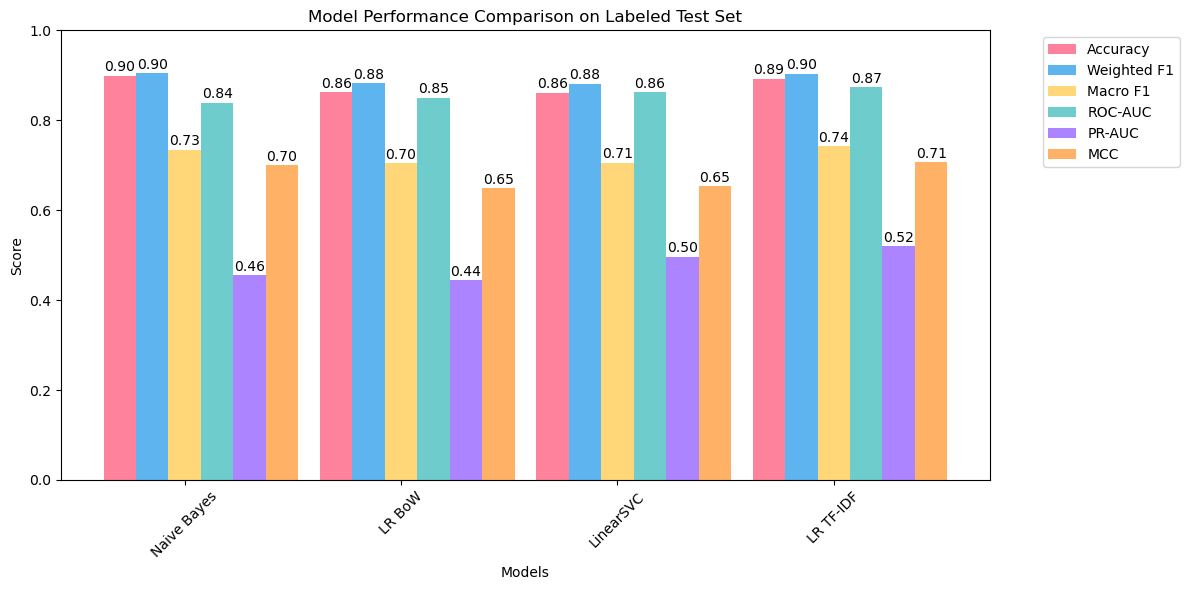

In [ ]:
plt.figure(figsize=(12, 6))

models = ['Naive Bayes', 'LR BoW', 'LinearSVC', 'LR TF-IDF']
y_preds = [y_pred_nb, y_pred_lr_bow, y_pred_svm, y_pred_lr_tfidf]

accuracies = [accuracy_score(y_test, pred) for pred in y_preds]
weighted_f1_scores = [f1_score(y_test, pred, average='weighted') for pred in y_preds]
macro_f1_scores = [f1_score(y_test, pred, average='macro') for pred in y_preds]

# Tính ROC-AUC 
from sklearn.metrics import roc_auc_score
roc_aucs = []
for pred in y_preds:
    # Chuyển y_test và y_pred thành one-hot encoding cho đa lớp
    y_test_onehot = pd.get_dummies(y_test).values
    pred_proba = np.zeros((len(pred), 3))  # 3 lớp: -1, 0, 1
    pred_proba[np.arange(len(pred)), pred + 1] = 1  # Ánh xạ -1->0, 0->1, 1->2
    roc_aucs.append(roc_auc_score(y_test_onehot, pred_proba, multi_class='ovr', average='macro'))

# Tính PR-AUC (Precision-Recall)
from sklearn.metrics import precision_recall_curve, auc
pr_aucs = []
for pred in y_preds:
    precision = dict()
    recall = dict()
    y_test_bin = (y_test == 0)  # Tập trung vào lớp neutral (0) làm lớp positive
    pred_bin = (pred == 0)
    precision[0], recall[0], _ = precision_recall_curve(y_test_bin, pred_bin)
    pr_aucs.append(auc(recall[0], precision[0]))

# Tính MCC
from sklearn.metrics import matthews_corrcoef
mcc_scores = [matthews_corrcoef(y_test, pred) for pred in y_preds]

x = np.arange(len(models))
width = 0.15

plt.bar(x - 2*width, accuracies, width, label='Accuracy', color='#FF6384', alpha=0.8)
plt.bar(x - width, weighted_f1_scores, width, label='Weighted F1', color='#36A2EB', alpha=0.8)
plt.bar(x, macro_f1_scores, width, label='Macro F1', color='#FFCE56', alpha=0.8)
plt.bar(x + width, roc_aucs, width, label='ROC-AUC', color='#4BC0C0', alpha=0.8)
plt.bar(x + 2*width, pr_aucs, width, label='PR-AUC', color='#9966FF', alpha=0.8)
plt.bar(x + 3*width, mcc_scores, width, label='MCC', color='#FF9F40', alpha=0.8)

for i, (acc, wf1, mf1, rocauc, prauc, mcc) in enumerate(zip(accuracies, weighted_f1_scores, macro_f1_scores, roc_aucs, pr_aucs, mcc_scores)):
    plt.text(i - 2*width, acc + 0.01, f'{acc:.2f}', ha='center')
    plt.text(i - width, wf1 + 0.01, f'{wf1:.2f}', ha='center')
    plt.text(i, mf1 + 0.01, f'{mf1:.2f}', ha='center')
    plt.text(i + width, rocauc + 0.01, f'{rocauc:.2f}', ha='center')
    plt.text(i + 2*width, prauc + 0.01, f'{prauc:.2f}', ha='center')
    plt.text(i + 3*width, mcc + 0.01, f'{mcc:.2f}', ha='center')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison on Labeled Test Set')
plt.xticks(x, models, rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1.0) 
plt.tight_layout()
plt.show()

In [17]:
test_df = pd.read_json('datasets/All_Beauty.json')
test_df['text'] = test_df['reviewText'].fillna('') + ' ' + test_df['summary'].fillna('')
test_df['text'] = test_df['text'].str.strip()
test_df = test_df[test_df['text'] != '']
test_df = test_df.dropna(subset=['overall'])

In [18]:
len(test_df)

5269

In [19]:
test_df[['overall', 'reviewText']].head()

,overall,reviewText
0,5,As advertised. Reasonably priced
1,5,Like the oder and the feel when I put it on my...
2,1,I bought this to smell nice after I shave. Wh...
3,5,HEY!! I am an Aqua Velva Man and absolutely lo...
4,5,If you ever want to feel pampered by a shampoo...


In [20]:
test_df['overall'].value_counts()

overall
5    4649
4     332
1     115
3     109
2      64
Name: count, dtype: int64

In [21]:
# TextBlob
test_df['textblob_polarity'] = test_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
test_df['textblob_pred'] = test_df['textblob_polarity'].apply(lambda x: 1 if x >= 0 else -1)

In [22]:
# VADER
sia = SentimentIntensityAnalyzer()
test_df['vader_compound'] = test_df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
test_df['vader_pred'] = test_df['vader_compound'].apply(lambda x: 1 if x >= 0.3 else (-1 if x <= -0.3 else 0))

In [23]:
# ML Models
test_bow = vectorizer_bow.transform(test_df['text'])
test_tfidf = vectorizer_tfidf.transform(test_df['text'])
test_df['nb_pred'] = nb_model.predict(test_bow)
test_df['lr_bow_pred'] = lr_model_bow.predict(test_bow)
test_df['svm_pred'] = svm_model.predict(test_tfidf)
test_df['lr_tfidf_pred'] = lr_model_tfidf.predict(test_tfidf)

In [24]:
test_df['overall_score'] = test_df['overall'].apply(lambda x: 1 if x >= 4 else (-1 if x <= 2 else 0))

In [25]:
print("\nDự đoán trên tập test không nhãn:")
print(test_df[['text', 'overall', 'textblob_pred', 'vader_pred', 'nb_pred', 'lr_bow_pred', 'svm_pred', 'lr_tfidf_pred']])


Dự đoán trên tập test không nhãn:
                                                   text  overall  \
0           As advertised. Reasonably priced Five Stars        5   
1     Like the oder and the feel when I put it on my...        5   
2     I bought this to smell nice after I shave.  Wh...        1   
3     HEY!! I am an Aqua Velva Man and absolutely lo...        5   
4     If you ever want to feel pampered by a shampoo...        5   
...                                                 ...      ...   
5264  I have genetic undereye darkness. Ive accepted...        5   
5265      I absolutely love this eye gel. As advertised        5   
5266  The eye gel is easy to apply and I use it morn...        5   
5267    Ok this eye gel is good stuff. Does it's thing!        5   
5268  This is the first eye gel/cream that actually ...        5   

      textblob_pred  vader_pred  nb_pred  lr_bow_pred  svm_pred  lr_tfidf_pred  
0                 1           0        1            0         0    

In [26]:
agreement = test_df[['textblob_pred', 'vader_pred', 'nb_pred', 'lr_bow_pred', 'svm_pred', 'lr_tfidf_pred']].eq(test_df['lr_tfidf_pred'], axis=0).all(axis=1).mean()
print(f"\nTỷ lệ đồng thuận giữa các phương pháp: {agreement:.2%}")


Tỷ lệ đồng thuận giữa các phương pháp: 71.65%


In [27]:
for method in ['textblob_pred', 'vader_pred', 'nb_pred', 'lr_bow_pred', 'svm_pred', 'lr_tfidf_pred']:
    print(f"\nPhân bố dự đoán ({method}):\n", test_df[method].value_counts().sort_index())


Phân bố dự đoán (textblob_pred):
 textblob_pred
-1     175
 1    5094
Name: count, dtype: int64

Phân bố dự đoán (vader_pred):
 vader_pred
-1     126
 0     399
 1    4744
Name: count, dtype: int64

Phân bố dự đoán (nb_pred):
 nb_pred
-1     121
 0      27
 1    5121
Name: count, dtype: int64

Phân bố dự đoán (lr_bow_pred):
 lr_bow_pred
-1     205
 0     478
 1    4586
Name: count, dtype: int64

Phân bố dự đoán (svm_pred):
 svm_pred
-1     449
 0     613
 1    4207
Name: count, dtype: int64

Phân bố dự đoán (lr_tfidf_pred):
 lr_tfidf_pred
-1     494
 0     514
 1    4261
Name: count, dtype: int64


In [28]:
test_df['overall_score'] = test_df['overall'].apply(lambda x: 1 if x >= 4 else (-1 if x <= 2 else 0))
print("\nSo sánh với overall_score (đối chiếu sơ bộ):")
for method in ['textblob_pred', 'vader_pred', 'nb_pred', 'lr_bow_pred', 'svm_pred', 'lr_tfidf_pred']:
    agreement_with_overall = (test_df[method] == test_df['overall_score']).mean()
    print(f"{method} agreement with overall_score: {agreement_with_overall:.2%}")


So sánh với overall_score (đối chiếu sơ bộ):
textblob_pred agreement with overall_score: 93.77%
vader_pred agreement with overall_score: 89.20%
nb_pred agreement with overall_score: 94.42%
lr_bow_pred agreement with overall_score: 84.40%
svm_pred agreement with overall_score: 79.03%
lr_tfidf_pred agreement with overall_score: 79.96%


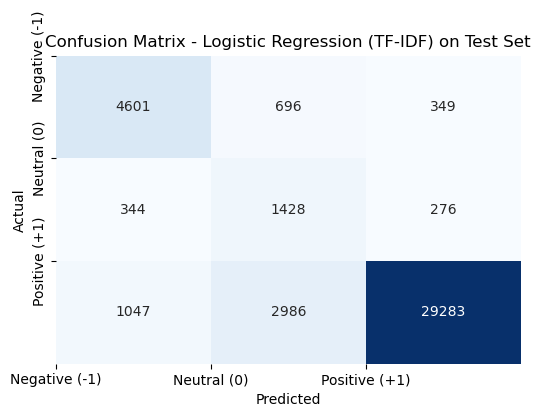

In [29]:
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression (TF-IDF) on Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=[0, 1, 2], labels=['Negative (-1)', 'Neutral (0)', 'Positive (+1)'])
plt.yticks(ticks=[0, 1, 2], labels=['Negative (-1)', 'Neutral (0)', 'Positive (+1)'])
plt.show()

Train counts: score
-1     28232
 0     10238
 1    166580
Name: count, dtype: int64
Test counts: overall_score
-1     179
 0     109
 1    4981
Name: count, dtype: int64
SVM counts: svm_pred
-1     449
 0     613
 1    4207
Name: count, dtype: int64


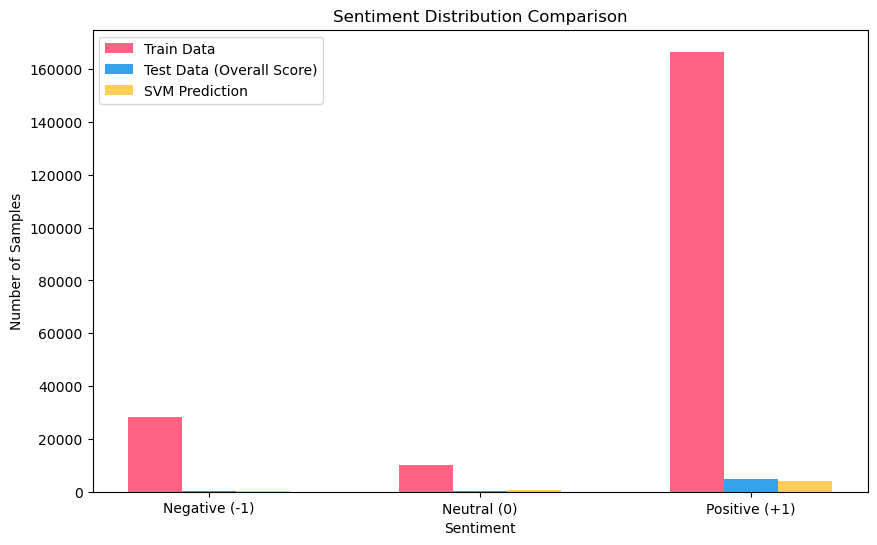

In [30]:
plt.figure(figsize=(10, 6))
train_counts = data['score'].value_counts().reindex([-1, 0, 1], fill_value=0)
test_counts = test_df['overall_score'].value_counts().reindex([-1, 0, 1], fill_value=0)
svm_counts = test_df['svm_pred'].value_counts().reindex([-1, 0, 1], fill_value=0)
labels = ['Negative (-1)', 'Neutral (0)', 'Positive (+1)']

x = np.arange(len(labels))
width = 0.25

print("Train counts:", train_counts)
print("Test counts:", test_counts)
print("SVM counts:", svm_counts)


plt.bar(np.arange(3) - 0.2, train_counts, width=0.2, label='Train Data', color='#FF6384')
plt.bar(np.arange(3), test_counts, width=0.2, label='Test Data (Overall Score)', color='#36A2EB')
plt.bar(np.arange(3) + 0.2, svm_counts, width=0.2, label='SVM Prediction', color='#FFCE56')
plt.xlabel('Sentiment')
plt.ylabel('Number of Samples')
plt.title('Sentiment Distribution Comparison')
plt.xticks(np.arange(3), labels)
plt.legend()
plt.show()

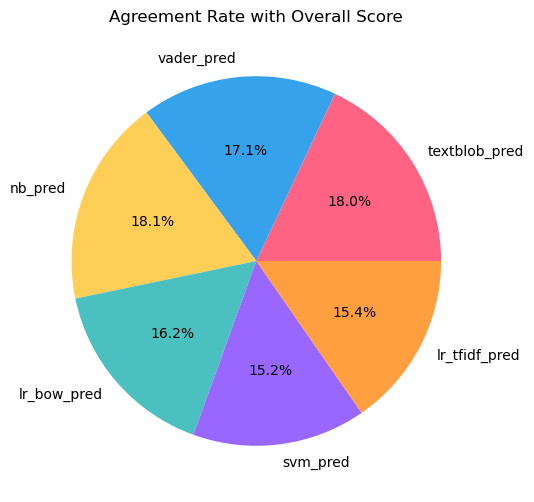

In [31]:
plt.figure(figsize=(8, 6))
methods = ['textblob_pred', 'vader_pred', 'nb_pred', 'lr_bow_pred', 'svm_pred', 'lr_tfidf_pred']
agreements = [(test_df[method] == test_df['overall_score']).mean() * 100 for method in methods]
plt.pie(agreements, labels=methods, autopct='%1.1f%%', colors=['#FF6384', '#36A2EB', '#FFCE56', '#4BC0C0', '#9966FF', '#FF9F40'])
plt.title('Agreement Rate with Overall Score')
plt.show()